<img src="https://img.freepik.com/free-vector/financial-forecast-illustration-flat-tiny-economical-persons-concept_126608-1324.jpg?size=626&ext=jpg&ga=GA1.2.1775781678.1609891200"></img>

<h1>💰Predict Future Sales Competiton💰: time series prediction with ARIMA</h1>

This is my second challenge on Kaggle, but my first for almost five years! When I joined, I had (still have) some very big issues in understanding not only the rules of submission, but also the data and ... what everything mean?

So, as I go along I will try to bring some clear understanding and also point to some fruitful discussions. Ok, here we go!

## 1. Competition Outline

In this competition we work with time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asked to predict total sales for every product and store in the next month.

But what is time series prediction?

>  *Time series forecasting is the use of a model to predict future values based on previously observed values.* 

## 2. Data 

All right, so what data are we provided for which we need to predict the future values?

- `sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015. It has 1034 unique values `item_id` that were sold at a given `shop_id` at `date_block_num` time.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015. 214k `item_id` sales to predict at `shop_id` for next `date_block_num` time.
- `sample_submission.csv` - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products. 22170
unique values, with the categories.
- item_categories.csv  - supplemental information about the items categories. 84
unique values.
- shops.csv- supplemental information about the shops. The name and sometimes the categories: TPK|ТЦ|ТК|ТРЦ|МТРЦ|ТЦ

## 3. Libraries 📚

Ok, that sounds good. But what libraries do we need to do the prediction?

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

In [2]:
# time-series prediction packages
from statsmodels.tsa.statespace import sarimax as smt # sarimax algorithm for actual predictions
from statsmodels.graphics.tsaplots import plot_pacf # partial auto-correlation plotting tool for stationarity test
from statsmodels.graphics.tsaplots import plot_acf # auto-correlation plotting tool for stationarity test
from statsmodels.tsa.arima_process import ArmaProcess # arma process for simulation 

In [3]:
sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")

import warnings

# settings
warnings.filterwarnings('ignore')


item_cat = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
sub = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
shop = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

## 3. Example: time series forecasting with ARMA

I didn't knew how to model time series so I started by learning about that. It seems that one of the very common model for that are Auto-Regressive Moving Average processes. You must know what are random walk, moving average process (MA) and autoregressive models (AR) before tackling this notebook where we mix everything up with ARMA model. 

There are notebooks about that there:

- [Understanding the random walk and the moving average](https://towardsdatascience.com/how-to-model-time-series-in-python-9983ebbf82cf)
- [A hands-on tutorial on AR(p) process for time series analysis in Python](https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401)
- [Understand and implement ARMA and ARIMA models for time series forcasting Python](https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d)

Ok, now that we are wise, let's do a little example on how to predict a financial stock with ARMA before we dive into our competition

### ARMA

an ARMA(p,q) is simply the combination of both Moving Average process and Auto Regressive process into a single equation. $y_t$ value is equal to:

$$y_t = \overbrace{c + \theta_1 \epsilon_{t-1} + \theta_{t-2} + ... + \theta_q \epsilon_{t-q}}^{Moving-Average(q)} + \\ \underbrace{\phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_q y_{t-p}}_{Auto-regression(p)}$$

Here would be a simulated ARMA model:

In [4]:
ar1 = np.array([1, 0.33])
ma1 = np.array([1, 0.9])
simulated_ARMA_data = ArmaProcess(ar1, ma1).generate_sample(nsample=10000)

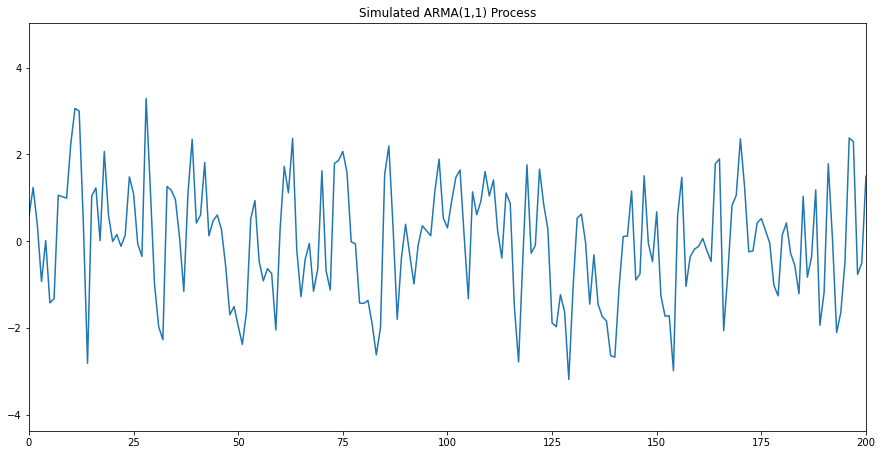

In [5]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(simulated_ARMA_data)
plt.title("Simulated ARMA(1,1) Process")
plt.xlim([0, 200])
plt.show()

The first (and most important) step in fitting an ARIMA model is the determination of the order of differencing needed to stationarize the series.

Differencing is a method of transforming a time series dataset. It can be used to remove the series dependence on time, so-called temporal dependence.

Normally, the correct amount of differencing is the lowest order of differencing that yields a time series which fluctuates around a well-defined mean value and whose autocorrelation function (ACF) plot decays fairly rapidly to zero, either from above or below. If the series still exhibits a long-term trend, or otherwise lacks a tendency to return to its mean value, or if its autocorrelations are are positive out to a high number of lags (e.g., 10 or more), then it needs a higher order of differencing

So let's take a look at the ACF and PACF plots:

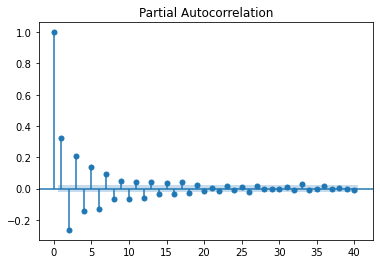

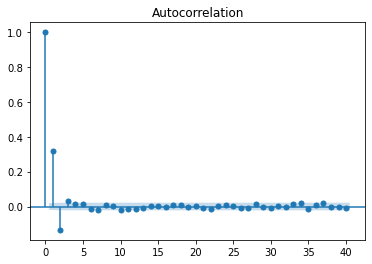

In [6]:
plot_pacf(simulated_ARMA_data);
plot_acf(simulated_ARMA_data);

As you can see, we cannot infer the order of the ARMA process by looking at these plots. In fact, looking closely, we can see some sinusoidal shape in both ACF and PACF functions. This suggests that both processes are in play.

Therefore, how can we make sure that we choose the right order for both the AR(p) and MA(q) processes?

We will need try different combinations of orders, fit an ARIMA model with those orders, and use a criterion for order selection.

This brings us to the topic of Akaike’s Information Criterion or AIC.

### Akaike Information Criterion

This criterion is useful for selecting the order (p,d,q) of an ARIMA model. The AIC is expressed as:

$$AIC = -2\log(L) + 2k$$

Where L is the likelihood of the data and k is the number of parameters.
In practice, we select the model with the lowest AIC compared to other models.

It is important to note that the AIC cannot be used to select the order of differencing (d). Differencing the data will the change the likelihood (L) of the data. The AIC of models with different orders of differencing are therefore not comparable.

Also, notice that since we select the model with the lowest AIC, more parameters will increase the AIC score and thus penalize the model. While a model with more parameters could perform better, the AIC is used to find the model with the least number of parameters that will still give good results.
A final note on AIC is that it can only be used relative to other models. A small AIC value is not a guarantee that the model will have a good performance on unsee data, or that its SSE will be small.

# SARIMAX

Let’s use Microoft stock and model the time series with an ARIMA(p,d,q) model.

In [7]:
! pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=06dbad789d1879d1c41b8fce5ed3ad060f7c54e2f5d921f31020eb22b3d4569b
  Stored in directory: /root/.cache/pip/wheels/aa/8a/36/59ed4f6fbcb6100967618eeb0696046bf9777a41ac2ff1f9b9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=7df4d021abd4d2754c52af3e4f5e420b1cb95ce6c6f9d2af36d8803a31d3a0c1
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


In [8]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get historical market data
hist = msft.history(period="5y")

In [9]:
df_settle = hist['Close'].resample('MS').ffill().dropna()

In [10]:
df_settle.tail()

Date
2020-10-01    211.418289
2020-11-01    201.477280
2020-12-01    215.713181
2021-01-01    221.908905
2021-02-01    239.099304
Freq: MS, Name: Close, dtype: float64

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_settle)
print('ADF result', result[0])
print('p-value = ', result[1])

critical_values = result[4]

for key, value, in critical_values.items():
  print("critical values (%s): %.3f" % (key, value))

ADF result 2.32592114014481
p-value =  0.9989710666347107
critical values (1%): -3.563
critical values (5%): -2.919
critical values (10%): -2.597


Here, the p-value is larger than 0.05, meaning the we cannot reject the null hypothesis stating that the time series is non-stationary.
Therefore, we must apply some transformation and some differencing to remove the trend and remove the change in variance.

### Finding model parameters by grid search

We could try to find the model parameters by detrending with a log-difference `np.log(df_settle)` and differenciating `df_settle.diff(seasonality)` and then run the Augmented Dickey-Fuller test again to see if we have a stationary time series.

Although these plots can give us a rough idea of the processes in play, it is better to test multiple scenarios and choose the model that yield the lowest AIC.

Therefore grid searching (p, d, q, s), allows to feed the data as it is without any transformation since SARIMAX will do the transformation for you under the hood.

We just need to find the model minimizing the AIC

In [12]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.api.tsa.statespace import SARIMAX

warnings.filterwarnings("ignore")

def arima_grid_search(dataframe, s):
  p = d = q = range(2)
  param_combinations = list(itertools.product(p, d, q))

  lowest_aic, pdq, pdqs = None, None, None

  total_iterations = 0
  for order in param_combinations:
    for (p, d, q) in param_combinations:
      seasonal_order = (p, d, q, s)
      total_iterations +=1
      try:
        model = SARIMAX(df_settle, order=order,
                        seasonal_order = seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        disp=False
                      )
        model_result = model.fit(maxiter=200, disp=False)

        if not lowest_aic or model_result.aic < lowest_aic:
          lowest_aic = model_result.aic
          pdq, pdqs = order, seasonal_order

      except Exception as ex:
        continue

  return lowest_aic, pdq, pdqs

In [13]:
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)

In [14]:
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f' % (lowest_aic))

ARIMA(1, 1, 0)x(1, 1, 0, 12)
Lowest AIC: 253.230


Therefore, this suggests are ARIMA model with an AR(1) process and a MA(0).

The order of differencing (d) process is 1. But it's not related to the AIC, it has been found by the grid search model itself.

## fitting the SARIMAX model

In [15]:
model = SARIMAX(
    df_settle, 
    order=order,
    seasonal_order = seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

model_results = model.fit(maxiter=200, disp=False)

Now, we can print a summary of the best model, which an ARIMA (1,1,0).

In [16]:
print(model_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -123.615
Date:                            Fri, 19 Feb 2021   AIC                            253.230
Time:                                    11:04:55   BIC                            257.809
Sample:                                03-01-2016   HQIC                           254.792
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0909      0.178     -0.512      0.609      -0.439       0.257
ar.S.L12      -0.6941      0.200   

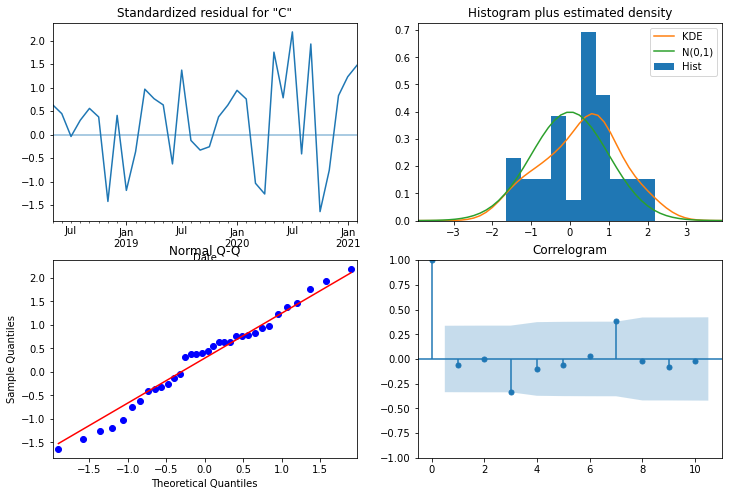

In [17]:
model_results.plot_diagnostics(figsize=(12,8));

From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from normality. Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise.

In [18]:
model_results.resid.describe()

count    60.000000
mean      2.180437
std      10.021413
min     -19.382343
25%      -2.414445
50%       1.917617
75%       6.745846
max      48.214378
dtype: float64

## Predicting the model

We are ready to plot the predictions of our model and forecast into the future:

In [19]:
n = len(df_settle.index)
prediction = model_results.get_prediction(
    start=n-14*5, #changed from 12
    end=n+5
)

prediction_ci = prediction.conf_int()

In [20]:
prediction_ci.head(3)

,lower Close,upper Close
2020-05-01,138.698549,174.675224
2020-06-01,156.305084,192.281758
2020-07-01,165.132779,201.109453


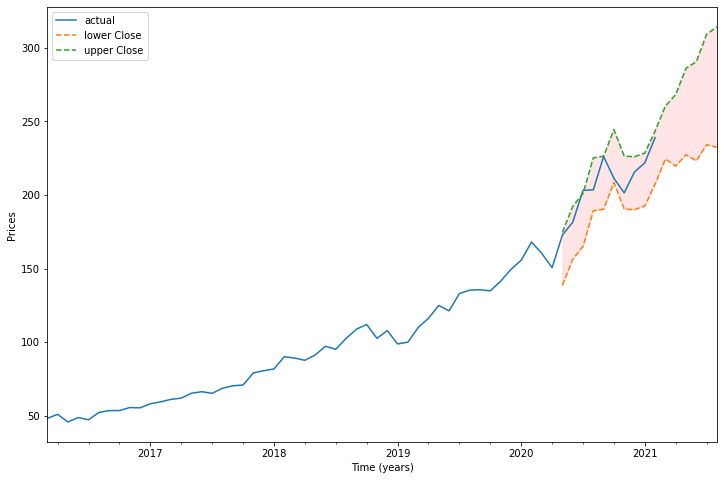

In [21]:
plt.figure(figsize=(12,8))
ax = df_settle['2008':].plot(label='actual')
prediction_ci.plot(
    ax=ax, style=['--', '--'],
    label='predicted/forecasted')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci,
                color='r', alpha= .1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

Now we know how to do time-series prediction! We are all set and ready for our competition.

## 4. Exploratory Data Analysis

First, let's visit the dataset `sales_train.csv` that we talked about previously.

In [22]:
#formating dates as a date object
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


So we have ~2M sales of items in the period we were given.

How do they look like?

In [23]:
sales_monthly = sales.groupby(
    ["date_block_num", "shop_id", "item_id"])["date","item_price",
                                              "item_cnt_day"].agg({
        "date":["min","max"],
        "item_price":"mean",
        "item_cnt_day":"sum"})

In [24]:
sales_monthly.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

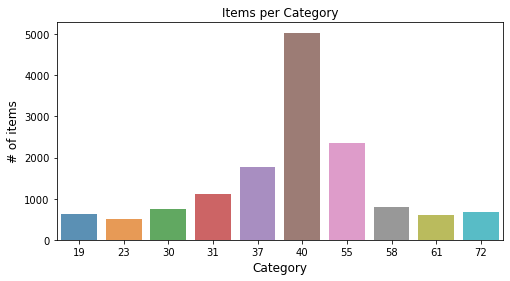

In [25]:
# number of items per cat 
items.head()
x = items.groupby(['item_category_id']).count() # but count is in column item_id ?
x = x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# plot
plt.figure(figsize=(8,4))
ax=sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel("# of items", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.show()


The sales by category seem to be unbalanced.

First let's compute the total sales per month and plot that data.



In [26]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
# ts = sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum()

In [27]:
out = sales.pivot_table(index='shop_id', 
                        columns='date_block_num',
                        values='item_cnt_day',
                        aggfunc='sum')
out = out.fillna(out.mean())
out.head()

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,3198.73913,2330.217391,2377.111111,2725.673913,2542.73913,2784.244444,2962.933333,2772.630435,...,2219.42,1791.446809,1782.913043,1655.893617,1643.068182,1491.023256,1469.465116,1573.309524,1694.023256,1614.909091
1,2947.0,3364.0,3198.73913,2330.217391,2377.111111,2725.673913,2542.73913,2784.244444,2962.933333,2772.630435,...,2219.42,1791.446809,1782.913043,1655.893617,1643.068182,1491.023256,1469.465116,1573.309524,1694.023256,1614.909091
2,1146.0,488.0,753.00000,583.000000,553.000000,832.000000,807.00000,875.000000,945.000000,795.000000,...,987.00,907.000000,762.000000,859.000000,843.000000,804.000000,785.000000,942.000000,822.000000,727.000000
3,767.0,798.0,959.00000,647.000000,710.000000,784.000000,721.00000,890.000000,1026.000000,793.000000,...,977.00,738.000000,741.000000,740.000000,731.000000,672.000000,535.000000,666.000000,745.000000,613.000000
4,2114.0,2025.0,2060.00000,285.000000,1211.000000,1464.000000,1378.00000,1713.000000,1536.000000,1482.000000,...,1188.00,980.000000,978.000000,899.000000,893.000000,793.000000,842.000000,947.000000,732.000000,831.000000


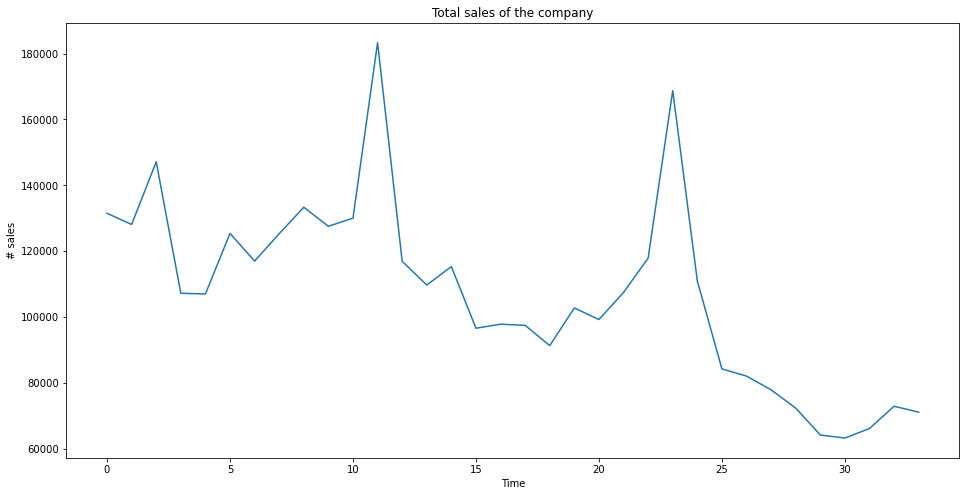

In [28]:
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.title("Total sales of the company")
plt.xlabel("Time")
plt.ylabel("# sales")
plt.show()

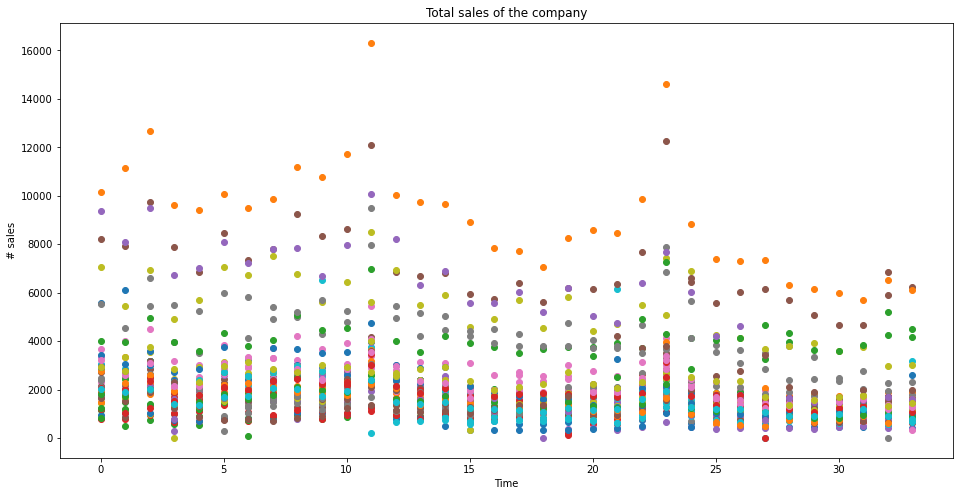

In [29]:
plt.figure(figsize=(16,8))
for i,row in out.iterrows():
  plt.scatter(out.columns, row)
plt.title("Total sales of the company")
plt.xlabel("Time")
plt.ylabel("# sales")
plt.show()

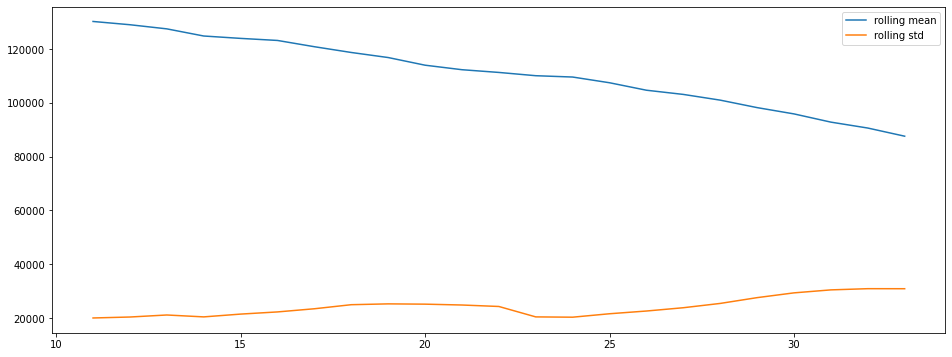

In [30]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(), label = "rolling mean")
plt.plot(ts.rolling(window=12, center=False).std(), label = "rolling std")
plt.legend()
plt.show()

There is clearly a seasonality and a trend.

Let's check that with a quick decomposition into Trend, seasonality and residuals.



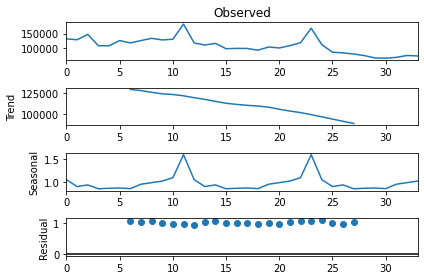

In [31]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="multiplicative")
fig=res.plot()

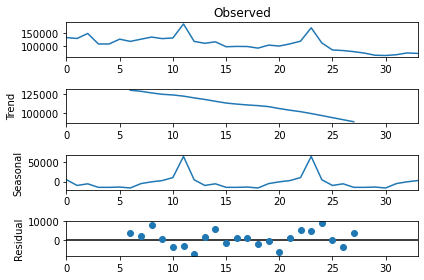

In [32]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="addidtive")
fig=res.plot()

Now I need to predict at the (shop,item_level)

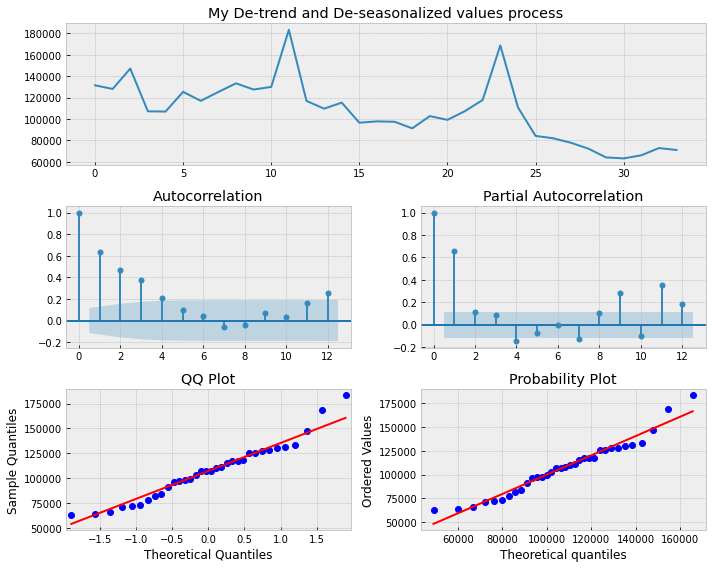

In [33]:
import statsmodels.api as smt
import statsmodels
import scipy.stats as scs
from pandas import Series

ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()

def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)

new_ts = difference(ts, 12)


def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        statsmodels.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        statsmodels.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        smt.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

max_lag = 12
_ = tsplot(ts.values, lags=max_lag,title="My De-trend and De-seasonalized values process");

# ARMA

We are now going to buil our model to predict the future sales for the company.

We first need to create a multi-index dataframe with `("date_block_num", "shop_id", "item_id")` as index in order to easily find the number of time an `item_id` was sold at month `date_block_num`.

In [34]:
sales_monthly = sales.groupby(
    ["date_block_num", "shop_id", "item_id"])["date", "item_price",
                                              "item_cnt_day"].agg({
    "date": ["min", "max"],
    "item_price": "mean",
    "item_cnt_day": "sum"})

In [35]:
sales_monthly.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

Each `"shop_id", "item_id"` is a time series for which we will find and create a SARIMAX model.

We now find these couples iterating through `test` and creating the related SARIMAX model if we have enough data (at least 33 month of sales)

In [36]:
import more_itertools as mit
from statsmodels.tsa.statespace.sarimax import SARIMAX


array = []

for i, row in test.iterrows():
   
    try:
        # We get all the dates/indexes in order to fill the blanks of the time series with 0s later on 
        # We have a KeyError issue at row['shop_id']:  5  row['item_id']:  5003 which I don't have in my local notebook
        existing_indexes = [x[0] 
                            for x in sales_monthly.loc[pd.IndexSlice[:, 
                            [row['shop_id']], [row['item_id']]], :].index]
        # We multiply the price of the item by the number of this kind of item sold
        ts = pd.DataFrame(sales_monthly.loc[pd.IndexSlice[:, # We have a key error here
                      [row['shop_id']], [row['item_id']]], :]['item_price'].values *
                      sales_monthly.loc[pd.IndexSlice[:, 
                      [row['shop_id']], [row['item_id']]], :]['item_cnt_day'].values).T.iloc[0]
        ts_values = list(ts.values)
        if ts.values != [] and len(ts.values) > 4:
          # if this item isn't sold every month, we need to fill the gaps in the 
          # sellings list
          if len(ts.values<3):
            all_indexes = list(range(33))
            insert_at_indexes = set(all_indexes) - set(existing_indexes)
            insert_at_indexes = [list(group) 
                        for group in mit.consecutive_groups(insert_at_indexes)][1:]
            insert_at_indexes = [item for sublist in insert_at_indexes for item in sublist]
            # we only take the last one 
            for insert_at in insert_at_indexes:
              ts_values[insert_at:insert_at] = [0.]
          best_aic = np.inf
          best_order = None
          best_model = None

          # we need to test different orders, but let's have a go with that ...
          ranges = range(1, 5)
          for difference in ranges:
              tmp_model = SARIMAX(ts_values, order=(0, 1, 0), trend='t').fit()
              tmp_aic = tmp_model.aic
              if tmp_aic < best_aic:
                  best_aic = tmp_aic
                  best_difference = difference
                  best_model = tmp_model
          if best_model is not None:
              y_hat = best_model.forecast()[0]
              if y_hat < 0:
                  y_hat = 0.5
          else:
              y_hat = 0.5
        else:
            y_hat = 0.5
    except KeyError:
        y_hat = 0.5
    d = {'id': row['ID'], 'item_cnt_month': y_hat}
    array.append(d)

df = pd.DataFrame(array)
df.reset_index(drop=True, inplace=True)

Allright ! We are all done, let's have a look at what we predicted.

In [37]:
df.head()

,id,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [38]:
df.to_csv("submission.csv")

In [39]:
 df.to_csv("submission.csv", index=False)

# Conclusion

And our score is ... 3556.23468 whereas the sample submission was 1.23646.

As we are calculating the root mean square error, the the differences between values (sample or population values) predicted by a model or an estimator and the values observed, this is not very good. 

We probably need to
- get the right orders.
- do further data cleaning:
- Maybe the (shop,item) couples which don't generate any revenues anymore are not detected despite.
- Maybe ARIMA isn't a good model for this case and we should rather use a RNN model?